In [1]:
from scipy import special
from scipy import optimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random as rand
from sam import greek
from datetime import date
from os.path import join
import math
from sklearn.metrics import mean_squared_error as sk_mse
import seaborn as sns

In [2]:
# MATLAB_drive = '/Users/clmn/MATLAB-Drive'
# behav_dir = MATLAB_drive + '/TM experiment/TM_behavior/behav_data/'
behav_dir = '../behav_data/'
today = date.today().strftime("%Y%m%d")

In [3]:
def switch_freq(subj):
    i = subj[2]
    switcher = {
        'L':(10,15,20),
        'H':(25,30,35)
    }
    return switcher.get(i,"Error : Invalid subj ID")

def set_subj(subj):
    f_ini, f_mid, f_fin = switch_freq(subj)
    freq_range = range(f_ini,f_fin+1)
    return f_ini,f_mid,f_fin,freq_range

In [4]:
def scatter_x_y(subj):
    df = pd.read_csv(join(behav_dir,'%s_Dis.txt'%subj), sep='\t', header=None )
    df['class'] = [f2+f1-30 for f1, f2 in zip(df[2],df[4])]
    ## before = -1, after = 1, NaN = 0
    df['decision'] = [1 if x=='after' else (-1 if x=='before' else 0) for x in df[6]]
    df['class.other'] = [-1 if a!=15 else 1 for a in df[2]]
    df['picked.other'] = [1 if a==b else 0 for a,b in zip(df['decision'],df['class.other'])]
    N = len(df[df['class']==1.0])
    temp = df.groupby('class').sum()
    ## y : probability
    y = temp['picked.other']/N
    ## x : classifier
    x = temp.index
    return x+f_mid, y

def func_ideal_observer(x, a,b,r,k):
    n = f_mid
    return 0.5*(1+special.erf( k/(a*k**r)**(0.5) * (x**b-n**b)/np.sqrt(x**(b*r)+n**(b*r)) ))

def func_error(x,s):
    ## Error function
    ## 'mu' means mean
    ## 's' means deviation
    ## constraint : mu = f_mid
    mu = f_mid
    return 0.5*(1+special.erf((x-mu)/(np.sqrt(2)*s)))

def func_logistic(x,b):
    ## Logistic function
    ## freeparameter : a, b
    ## 'a' can be interpreted as the 75% threshold
    ## 'b' as a scaling factor that is inversely related to the slope of the psychometric function.
    ## constraint : a = f_mid
    a = f_mid
    return special.expit((x-a)/b)

def func_Weibull(x, a,b):
    ## Weibull cumulative distribution function
    ## 'a' summarises the effect of the stimulus
    ## 'b' reflets to the effect of noise
    g = 0.5 # chance level
    y = []
    for temp in x:
        k = temp - f_mid
        if k > 0:
            y.append(1 - (1-g)*np.exp(-a * (k**b)))
        elif k == 0:
            y.append(g)
        else:
            y.append(g*np.exp(-a * ((-k)**b))) # reverse Weibull cdf
    return np.asarray(y)

## Psychometric Curve Fitting

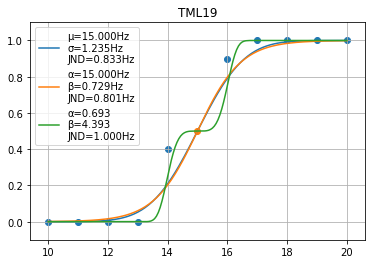

In [5]:
subj = 'TML19'
f_ini,f_mid,f_fin,freq_range = set_subj(subj)
xdata, prob = scatter_x_y(subj)
dx = 2**(-4)
## x array to plot curves
x = np.arange(f_ini,f_fin+dx,dx)

## error function
# test_func = func_error
# params, params_covariance = optimize.curve_fit(
#     test_func, xdata, prob, maxfev=500,
#     p0=[f_mid+5*(rand()-0.5),10*rand()]
# )
# JND=special.erfinv(0.5)*(np.sqrt(2)*params[1]); # JND for 75%
# plt.plot(
#     x, test_func(x, *params),
#     label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('mu'),params[0],greek('sigma'),params[1],JND)
# )
test_func = func_error
params, params_covariance = optimize.curve_fit(
    test_func, xdata, prob, maxfev=500,
    p0=[10*rand()]
)
JND=special.erfinv(0.5)*(np.sqrt(2)*params); # JND for 75%
plt.plot(
    x, test_func(x, *params),
    label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('mu'),f_mid,greek('sigma'),params,JND)
)

## logistic function
# test_func = func_logistic
# a_max, b_max = f_fin, 20.
# params, params_covariance = optimize.curve_fit(
#     test_func, xdata, prob, p0=[f_mid+5*(rand()-0.5),b_max*rand()], maxfev=500,
#     bounds=([dx,dx], [a_max,b_max])
# )
# JND = params[1]*np.log(3)+params[0] - f_mid
# plt.plot(x, test_func(x, *params), label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND))
test_func = func_logistic
b_max = 20.
params, params_covariance = optimize.curve_fit(
    test_func, xdata, prob, p0=[b_max*rand()], maxfev=500,
    bounds=([dx], [b_max])
)
JND = params*np.log(3)
plt.plot(x, test_func(x, *params), label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('alpha'),f_mid,greek('beta'),params,JND))

## Weibull function
test_func = func_Weibull
a_max, b_max = 5., 10.
params, params_covariance = optimize.curve_fit(
    test_func, xdata, prob,
    p0=[a_max*rand(),b_max*rand()],
    maxfev=500,
    bounds=([dx,dx], [a_max,b_max])
)
JND = (np.log(2)/params[0])**(1./params[1])
plt.plot(
    x, test_func(x, *params),
    label='%s=%.3f\n%s=%.3f\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND)
)

plt.scatter(x=xdata,y=prob)
plt.scatter(x=[f_mid],y=[0.5])
plt.legend(loc='best')
plt.ylim([-.1,1.1])

plt.title(subj)
plt.grid()
#plt.savefig(fname=today+'_'+subj+'_curve.png',dpi=300)

## Code test for raw TML data

In [6]:
from TM import curve_fit

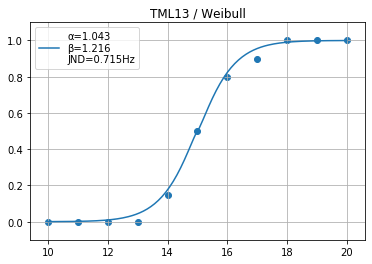

In [7]:
params = curve_fit('TML13',3)

## Data modify

In [35]:
# subj = 'TML29'
# f_ini,f_mid,f_fin,freq_range = set_subj(subj)

# df = pd.read_csv(join(behav_dir,subj,'behav_data_Dis.dat'), sep='\t', header=None )

# dg = pd.DataFrame(columns=['Block', 'Trial', 'f1', 'ISI1', 'f2', 'ISI2', 'decision', 'time_taken', 'ISI3'])

# ## cut off a column 'correcness' and separate trial classifier to block, trial
# for i,x in enumerate(df[0]):
#     dg.loc[i,'Block'], dg.loc[i,'Trial'] = math.floor(x/1e4), int(x%1e4)
#     dg.loc[i,'time_taken'] = '%.3f'%df.loc[i,7]

# dg['f1'] = df[1]
# dg['ISI1'] = df[2]
# dg['f2'] = df[3]
# dg['ISI2'] = df[4]
# dg['decision'] = df[5]
# dg['ISI3'] = df[8]

# dg.to_csv(join(behav_dir,'%s_Dis.txt'%subj[:5]), header=None, index=False, sep='\t', na_rep='NaN')
# dg

,Block,Trial,f1,ISI1,f2,ISI2,decision,time_taken,ISI3
0,1,1,15.0,6.5,10.0,3,before,0.640,5
1,1,2,15.0,7.5,16.0,2,after,0.531,6
2,1,3,15.0,3.5,13.0,6,after,0.575,2
3,1,4,15.0,4.5,14.0,5,before,0.603,3
4,1,5,12.0,3.5,15.0,6,after,0.502,2
...,...,...,...,...,...,...,...,...,...
95,10,6,12.0,5.5,15.0,4,after,0.442,4
96,10,7,20.0,3.5,15.0,6,before,0.446,2
97,10,8,18.0,7.5,15.0,2,before,0.546,6
98,10,9,19.0,7.5,15.0,2,before,0.534,6


# Parameter Space

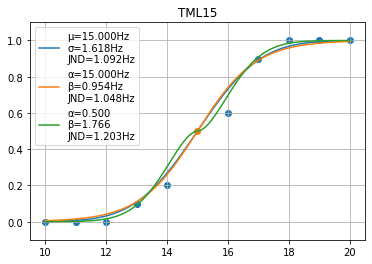

In [5]:
subj = 'TML15'
f_ini,f_mid,f_fin,freq_range = set_subj(subj)
xdata, ydata = scatter_x_y(subj)
dx = 2**(-4)
## x array to plot curves
x = np.arange(f_ini,f_fin+dx,dx)

## error function
# test_func = func_error
# params, params_covariance = optimize.curve_fit(
#     test_func, xdata, ydata, maxfev=500,
#     p0=[f_mid+5*(rand()-0.5),10*rand()]
# )
# JND=special.erfinv(0.5)*(np.sqrt(2)*params[1]); # JND for 75%
# plt.plot(
#     x, test_func(x, *params),
#     label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('mu'),params[0],greek('sigma'),params[1],JND)
# )
test_func = func_error
params, params_covariance = optimize.curve_fit(
    test_func, xdata, ydata, maxfev=500,
    p0=[10*rand()]
)
JND=special.erfinv(0.5)*(np.sqrt(2)*params); # JND for 75%
plt.plot(
    x, test_func(x, *params),
    label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('mu'),f_mid,greek('sigma'),params,JND)
)

## logistic function
# test_func = func_logistic
# a_max, b_max = f_fin, 20.
# params, params_covariance = optimize.curve_fit(
#     test_func, xdata, ydata, p0=[f_mid+5*(rand()-0.5),b_max*rand()], maxfev=500,
#     bounds=([dx,dx], [a_max,b_max])
# )
# JND = params[1]*np.log(3)+params[0] - f_mid
# plt.plot(x, test_func(x, *params), label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND))
test_func = func_logistic
b_max = 20.
params, params_covariance = optimize.curve_fit(
    test_func, xdata, ydata, p0=[b_max*rand()], maxfev=500,
    bounds=([dx], [b_max])
)
JND = params*np.log(3)
plt.plot(x, test_func(x, *params), label='%s=%.3fHz\n%s=%.3fHz\nJND=%.3fHz'%(greek('alpha'),f_mid,greek('beta'),params,JND))

## Weibull function
test_func = func_Weibull
a_max, b_max = 5., 10.
params, params_covariance = optimize.curve_fit(
    test_func, xdata, ydata,
    p0=[a_max*rand(),b_max*rand()],
    maxfev=500,
    bounds=([dx,dx], [a_max,b_max])
)
JND = (np.log(2)/params[0])**(1./params[1])
plt.plot(
    x, test_func(x, *params),
    label='%s=%.3f\n%s=%.3f\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND)
)

plt.scatter(x=xdata,y=ydata)
plt.scatter(x=[f_mid],y=[0.5])
plt.legend(loc='best')
plt.ylim([-.1,1.1])

plt.title(subj)
plt.grid()
#plt.savefig(fname=today+'_'+subj+'_curve.png',dpi=300)

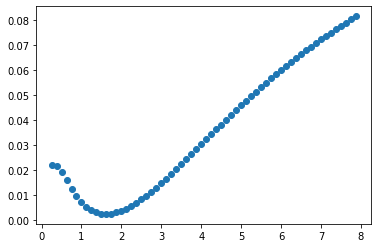

In [6]:
## Error function
test_func = func_error
p_ini, p_fin, dp = 2**(-2), 2**(3), 2**(-3)
p_set = np.arange(p_ini,p_fin,dp)
mse = []
for p in p_set:
    y_pred = test_func(xdata,p)
    mse.append(sk_mse(ydata,y_pred))
plt.scatter(p_set,mse)

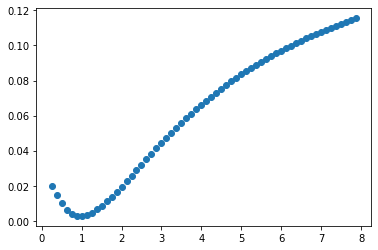

In [7]:
## Logistic function
test_func = func_logistic
p_ini, p_fin, dp = 2**(-2), 2**(3), 2**(-3)
p_set = np.arange(p_ini,p_fin,dp)
mse = []
for p in p_set:
    y_pred = test_func(xdata,p)
    mse.append(sk_mse(ydata,y_pred))
plt.scatter(p_set,mse)

In [14]:
## Weibull function
test_func = func_Weibull
a_ini, a_fin, da = 2**(-9), 2**(0), 2**(-5)
a_set = np.arange(a_ini,a_fin,da)
b_ini, b_fin, db = 2**(-9), 2**(2), 2**(-5)
b_set = np.arange(b_ini,b_fin,db)
df = pd.DataFrame()
for a in a_set:
    for b in b_set:
        y_pred = test_func(xdata,a,b)
        mse = sk_mse(ydata,y_pred)
        df = df.append({'a':a,'b':b,'mse':mse,'log_mse':np.log(mse)}, ignore_index=True)
df

,a,b,log_mse,mse
0,0.001953,0.001953,-1.654542,0.191180
1,0.001953,0.033203,-1.654693,0.191151
2,0.001953,0.064453,-1.654851,0.191121
3,0.001953,0.095703,-1.655015,0.191089
4,0.001953,0.126953,-1.655186,0.191057
...,...,...,...,...
4091,0.970703,3.845703,-5.044282,0.006446
4092,0.970703,3.876953,-5.044281,0.006446
4093,0.970703,3.908203,-5.044281,0.006446
4094,0.970703,3.939453,-5.044280,0.006446


In [26]:
dg = df[df.log_mse == df.log_mse.min()]
a_opt = dg.a
b_opt = dg.b
dg

,a,b,log_mse,mse
2104,0.501953,1.751953,-6.182347,0.002066


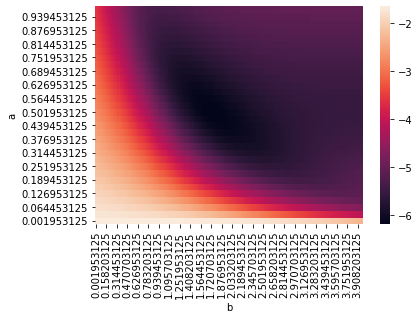

In [17]:
temp = df.pivot(index='a', columns='b').log_mse
ax = sns.heatmap(temp)
ax.invert_yaxis()

Text(0, 0.5, 'a')

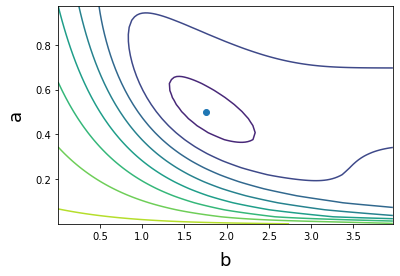

In [28]:
plt.contour(temp.columns,temp.index,temp)
plt.scatter(x=b_opt,y=a_opt)
plt.xlabel("b", fontsize=18, labelpad=10)
plt.ylabel("a", fontsize=18, labelpad=10)

# Performance Evaluation

### Q1

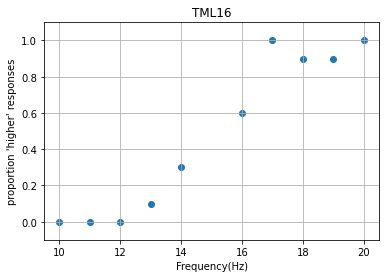

In [41]:
subj = 'TML16'
f_ini,f_mid,f_fin,freq_range = set_subj(subj)
xdata, ydata = scatter_x_y(subj)
plt.scatter(x=xdata,y=ydata)
# plt.scatter(x=[f_mid],y=[0.5])
plt.ylim([-.1,1.1])
plt.xlabel("Frequency(Hz)")
plt.ylabel("proportion 'higher' responses")
plt.title(subj)
plt.grid()
plt.savefig("%s.png"%subj, dpi=300)

### Q2

In [42]:
## Weibull function
test_func = func_Weibull
a_ini, a_fin, da = 2**(-9), 2**(0), 2**(-6)
a_set = np.arange(a_ini,a_fin,da)
b_ini, b_fin, db = 2**(-9), 2**(3), 2**(-5)
b_set = np.arange(b_ini,b_fin,db)
df = pd.DataFrame()
for a in a_set:
    for b in b_set:
        y_pred = test_func(xdata,a,b)
        mse = sk_mse(ydata,y_pred)
        df = df.append({'a':a,'b':b,'mse':mse,'log_mse':np.log(mse)}, ignore_index=True)
df

,a,b,log_mse,mse
0,0.001953,0.001953,-1.730370,0.177219
1,0.001953,0.033203,-1.730527,0.177191
2,0.001953,0.064453,-1.730691,0.177162
3,0.001953,0.095703,-1.730861,0.177132
4,0.001953,0.126953,-1.731038,0.177100
...,...,...,...,...
16379,0.986328,7.845703,-4.727530,0.008848
16380,0.986328,7.876953,-4.727530,0.008848
16381,0.986328,7.908203,-4.727530,0.008848
16382,0.986328,7.939453,-4.727530,0.008848


In [43]:
dg = df[df.log_mse == df.log_mse.min()]
a_opt, b_opt = dg.a.values[0], dg.b.values[0]
dg

,a,b,log_mse,mse
5972,0.361328,2.626953,-5.813183,0.002988


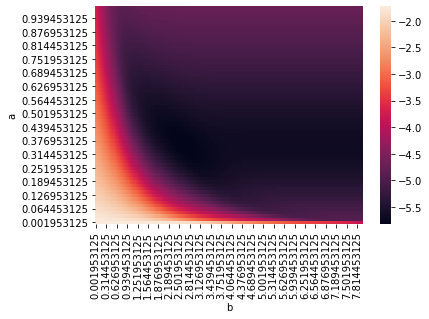

In [44]:
temp = df.pivot(index='a', columns='b').log_mse
ax = sns.heatmap(temp)
ax.invert_yaxis()

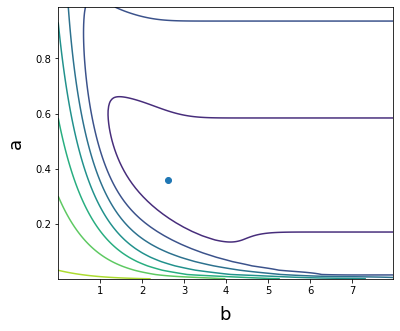

In [58]:
plt.figure(figsize=(6,5))
plt.contour(temp.columns,temp.index,temp)
plt.scatter(x=b_opt,y=a_opt)
plt.xlabel("b", fontsize=18, labelpad=10)
plt.ylabel("a", fontsize=18, labelpad=10)
plt.savefig("%s_parameters.png"%subj[:5], dpi=300)

### Q3

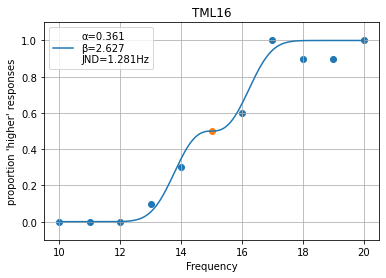

In [46]:
## Weibull function
params = [a_opt, b_opt]
JND = (np.log(2)/params[0])**(1./params[1])

## x array to plot curves
dx = 2**(-4)
x = np.arange(f_ini,f_fin+dx,dx)

plt.plot(
    x, func_Weibull(x, *params),
    label='%s=%.3f\n%s=%.3f\nJND=%.3fHz'%(greek('alpha'),params[0],greek('beta'),params[1],JND)
)

plt.scatter(x=xdata,y=ydata)
plt.scatter(x=[f_mid],y=[0.5])

plt.legend(loc='best')
plt.xlabel("Frequency")
plt.ylabel("proportion 'higher' responses")
plt.ylim([-.1,1.1])
plt.title(subj)
plt.grid()
plt.savefig("%s_weibull.png"%subj[:5], dpi=300)